In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
from config import api_key
from census import Census
from us import states

## Defining census_api functions

In [2]:
# census_api() function, returning the census data of a given year.
def census_data(YEAR):
    c = Census(api_key, year=YEAR)
    raw_data = c.acs5.get(('NAME', 'B19013_001E', 'B19301_001E', 'B23025_003E',
                       'B23025_004E', 'B23025_005E', 'B01003_001E', "B01002_001E", "B17001_002E"), {'for':'state:*'})
    census_df_raw = pd.DataFrame(raw_data)
    census_df_raw = census_df_raw.rename(columns = {'state': 'State#',
                          'NAME': 'State', 
                          'B01003_001E':'Total_population',
                          'B23025_003E':'Employable_civilians',
                          'B23025_004E':'Employed_civilians', 
                          'B23025_005E':'Unemployed_civilians', 
                          'B19013_001E':'Income_median',
                          'B19301_001E':'Income_per_capita',
                          "B01002_001E":'median age',
                          "B17001_002E":'Poverty_count'    
    })
    census_df_raw = census_df_raw.sort_values('State#').reset_index(drop=True)
    # reformatting census data
    census_df = census_df_raw.loc[:,['State', 'Total_population', 'Income_median', 'Income_per_capita']]
    census_df['Poverty_rate'] = census_df_raw.Poverty_count/census_df_raw.Total_population
    census_df['Unemployment_rate'] = census_df_raw.Unemployed_civilians/census_df_raw.Employable_civilians
    state_df = pd.read_csv('Resources/state_centroids.csv')
    census_df = pd.merge(census_df, state_df, on = 'State')
    census_df = census_df.set_index('State')
    return census_df

In [3]:
# Preparing the vote data of a given year.
csvfile = 'Resources/1976-2016-president.tab'
vote_df = pd.read_csv(csvfile, sep='\t', header=(0))
# Fixing the party label for 2012 minnesota democrat votes
vote_df = vote_df.replace('democratic-farmer-labor', 'democrat')

In [4]:
def vote_data(YEAR):
    demo_raw = vote_df.loc[(vote_df.year == YEAR)&(vote_df.party == 'democrat'), ['state', 'candidatevotes']]
    demo = demo_raw.groupby('state')['candidatevotes'].sum()
    rep_raw = vote_df.loc[(vote_df.year == YEAR)&(vote_df.party == 'republican'),['state', 'candidatevotes']]
    rep = rep_raw.groupby('state')['candidatevotes'].sum()
    total = vote_df.loc[(vote_df.year == YEAR), ['state', 'totalvotes']].groupby('state').mean()['totalvotes'] 
    vote_df_year = pd.concat([demo, rep, total],axis=1)
    vote_df_year.columns = [str(YEAR)+'_democrat_votes', str(YEAR)+'_republican_votes', str(YEAR)+'_total_votes']
    return vote_df_year

In [5]:
# Merging data for a given year. The function takes 3 arguments: dataframe1, dataframe2, year
def get_dataset(YEAR):
    dataset = census_data(YEAR).merge(vote_data(YEAR), left_index=True, right_index=True)
    dataset['votes difference'] = dataset[str(YEAR)+'_democrat_votes'] - dataset[str(YEAR)+'_republican_votes']
    dataset.loc[dataset['votes difference']<0, 'winner'] = 'Republican'
    dataset.loc[dataset['votes difference']>0, 'winner'] = 'Democrat'
    return dataset

In [68]:
data_2016 = get_dataset(2016)
data_2012 = get_dataset(2012)

In [7]:
data_2016.head(3)

,Total_population,Income_median,Income_per_capita,Poverty_rate,Unemployment_rate,Latitude,Longitude,2016_democrat_votes,2016_republican_votes,2016_total_votes,votes difference,winner
Alabama,4841164.0,44758.0,24736.0,0.179433,0.082856,32.7794,-86.8287,729547,1318255,2123372,-588708,Republican
Alaska,736855.0,74444.0,34191.0,0.098834,0.078468,64.0685,-152.2782,116454,163387,318608,-46933,Republican
Arizona,6728577.0,51340.0,26686.0,0.173237,0.079880,34.2744,-111.6602,1161209,1252401,2573165,-91192,Republican


# training data 2016

In [55]:
X = data_2016[['Total_population', 'Income_median', 'Income_per_capita', 'Unemployment_rate', 'Poverty_rate', 'Latitude', 'Longitude']]
y = data_2016['winner']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 5)

* training decision_tree classifier

In [56]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
feature_importances = pd.DataFrame(decision_tree.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
Income_per_capita,0.588585
Latitude,0.163399
Longitude,0.158985
Income_median,0.046296
Poverty_rate,0.042735
Total_population,0.000000
Unemployment_rate,0.000000


In [57]:
from sklearn.metrics import classification_report, confusion_matrix

In [58]:
# y_predict_train = decision_tree.predict(X_train)
# y_predict_train
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)

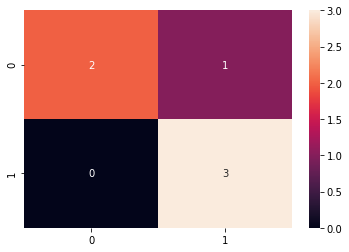

In [59]:
y_predict_test = decision_tree.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [60]:
# print(classification_report(y_test, y_predict_test))

# decision tree 2012 data
* X_2012, y_2012, y_predict_test_2012

In [61]:
X_2012 = data_2012[['Total_population', 'Income_median', 'Income_per_capita', 'Unemployment_rate', 'Poverty_rate', 'Latitude', 'Longitude']]
y_2012 = data_2012['winner']

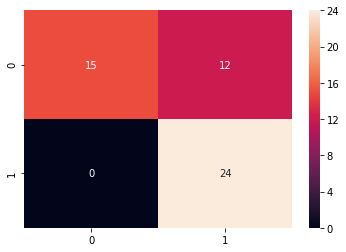

In [62]:
y_predict_test_2012 = decision_tree.predict(X_2012)
# y_predict_test_2012
cm_2012 = confusion_matrix(y_2012, y_predict_test_2012)
sns.heatmap(cm_2012, annot=True)

# RandomForest classifier
* rf_model

In [63]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [64]:
# y_predict_train = rf_model.predict(X_train)
# y_predict_train
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)

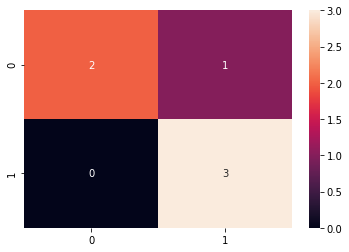

In [65]:
y_predict_test = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

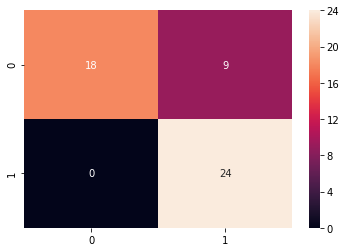

In [66]:
y_predict_rf_2012 = rf_model.predict(X_2012)
cm = confusion_matrix(y_2012, y_predict_rf_2012)
sns.heatmap(cm, annot=True)

In [67]:
# data_2012['prediction'] = y_predict_rf_2012
# data_2012[['winner','prediction']]

# master_df

In [72]:
data_2012_2016 = pd.concat([data_2012.reset_index(), data_2016.reset_index()], ignore_index=True, axis=0)
data_2012_2016

C:\Users\zhan3\Anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,2012_democrat_votes,2012_republican_votes,2012_total_votes,2016_democrat_votes,2016_republican_votes,2016_total_votes,Income_median,Income_per_capita,Latitude,Longitude,Poverty_rate,Total_population,Unemployment_rate,index,votes difference,winner
0,795696.0,1255925.0,2074338.0,NaN,NaN,NaN,43160.0,23587.0,32.7794,-86.8287,0.176310,4777326.0,0.102629,Alabama,-460229,Republican
1,122640.0,164676.0,300495.0,NaN,NaN,NaN,69917.0,32537.0,64.0685,-152.2782,0.093696,711139.0,0.084216,Alaska,-42036,Republican
2,1025232.0,1233654.0,2299254.0,NaN,NaN,NaN,50256.0,25571.0,34.2744,-111.6602,0.167679,6410979.0,0.097744,Arizona,-208422,Republican
3,394409.0,647744.0,1069468.0,NaN,NaN,NaN,40531.0,22007.0,34.8938,-92.4426,0.181839,2916372.0,0.085633,Arkansas,-253335,Republican
4,7854285.0,4839958.0,13038547.0,NaN,NaN,NaN,61400.0,29551.0,37.1841,-119.4696,0.149768,37325068.0,0.110285,California,3014327,Democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,NaN,NaN,NaN,1981473.0,1769443.0,3982752.0,66149.0,34967.0,37.5215,-78.8537,0.110906,8310301.0,0.059495,Virginia,212030,Democrat
98,NaN,NaN,NaN,1742718.0,1221747.0,3317019.0,62848.0,32999.0,47.3826,-120.4472,0.124875,7073146.0,0.068426,Washington,520971,Democrat
99,NaN,NaN,NaN,188794.0,489371.0,713051.0,42644.0,24002.0,38.6409,-80.6227,0.172288,1846092.0,0.075423,West Virginia,-300577,Republican
100,NaN,NaN,NaN,1382536.0,1405284.0,2976150.0,54610.0,29253.0,44.6243,-89.9941,0.123979,5754798.0,0.055013,Wisconsin,-22748,Republican


In [81]:
X = data_2012_2016[['Total_population', 'Income_median', 'Income_per_capita', 'Unemployment_rate', 'Poverty_rate', 'Latitude', 'Longitude']]
y = data_2012_2016['winner']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 5)

* training decision_tree classifier

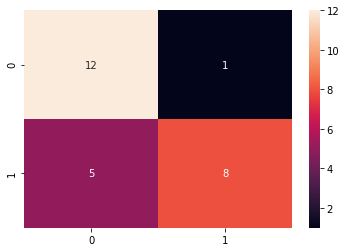

In [82]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train,y_train)
feature_importances = pd.DataFrame(decision_tree.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

from sklearn.metrics import classification_report, confusion_matrix

# y_predict_train = decision_tree.predict(X_train)
# y_predict_train
# cm = confusion_matrix(y_train, y_predict_train)
# sns.heatmap(cm, annot=True)

y_predict_test = decision_tree.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)